# Midterm Project

In [1]:
#Import relevant libraries
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import quad
import time

## Task 1: Find c to normalize g(x)

Integral from x1 to infinity: 0.9999999999999996


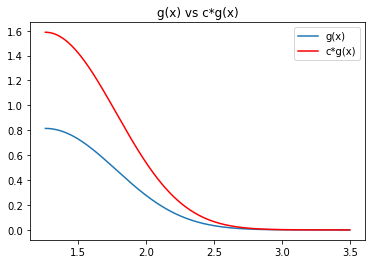

In [2]:
#Plot g_x and c*g_x
x1 = 2**(1/3)
x = np.linspace(x1,3.5,1000)
g_x = x**2*np.exp(-x**3/3)
c = np.exp(2/3)
plt.title("g(x) vs c*g(x)")
plt.plot(x,g_x, label = "g(x)")
plt.plot(x,c*g_x,'r' , label = "c*g(x)")
plt.legend()

#Integrate c*g_x from x1 to infinity
def integrand(x):
    return np.exp(2/3)*x**2*np.exp(-x**3/3)
ans, err = quad(integrand, x1, np.inf)
print("Integral from x1 to infinity: " + str(ans))

## Task 2: Define function that computes CDF

In [3]:
#CDF Function definition
def CDF(x):
    if x >= 2**(1/3):
        F_s = 1-np.exp((2-x**3)/3)
        return F_s
    else:
        return 0

#Compute CDF for any value of x
x_cdf = 2
print(CDF(x_cdf))


0.8646647167633873


## Task 3 & 4: Implement baseline sampling algorithm

Time elapsed to calclulate 1000000 samples: 80.78408241271973ms


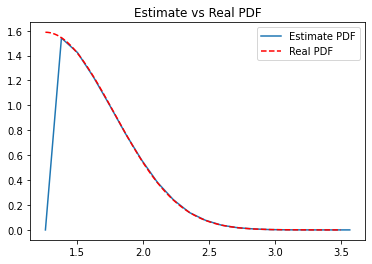

In [4]:
#Set number of samples
nsamples = 1000000

#use time library to calculate time to generate samples
t = time.time()
x_s = (2-3*np.log(1-np.random.rand(nsamples,1)))**(1/3)
elapsed = time.time() - t

#Prints time elapsed 
print("Time elapsed to calclulate "+str(nsamples)+" samples: " +str(elapsed*1000) + "ms")

#Generates bins of size delta
delta = .05
xmin = min(x_s)
xmax = max(x_s)
bincenters = np.linspace(xmin,xmax,int(1/delta))

#PDF Estimate
pdf_est = np.zeros(len(bincenters))
for i in range(1,len(bincenters)):
    pdf_est[i] = np.count_nonzero((x_s > bincenters[i]-delta/2) & (x_s <= bincenters[i]+delta/2) )/nsamples/delta; 

#Plots PDF Estimate and Real PDF
plt.title("Estimate vs Real PDF")
plt.plot(bincenters,pdf_est, label = "Estimate PDF")
plt.plot(x,c*g_x, 'r--',label = "Real PDF")
plt.legend()

## Task 5: Find x1, ... , xn for n = 4, 64, 256

In [5]:
#Function definition

#Funtion used to integrate PDF
def integrand(x):
    return np.exp(2/3)*x**2*np.exp(-x**3/3)

#Function used to calculate y value of PDF
def y_x(x):
    y = np.exp(2/3)*x**2*np.exp(-x**3/3)
    return y

#Function used to calculate x values using bisection method
def bisection_x(x1, x_pre, A):
    y_k = y_x(x_pre)
    xmin = x_pre
    xmax = 100
    tol = 10**(-12)
    
    while xmax - xmin > tol:
        x = (xmax + xmin)/2
        if (x-x1)*(y_k-y_x(x)) > A:
            xmax = x
        elif (x-x1)*(y_k-y_x(x)) < A:
            xmin = x
    return x

#Function used to compute area of rectangles based on x and y values 
def compute_area(n, A_est):
    A = np.zeros(n)
    x = np.zeros(n)
    y = np.zeros(n)

    x[0] = 2**(1/3)
    y[0] =  y_x(x[0])


    for i in range(1,n):
        if i < n:
            x[i] = bisection_x(x[0],x[i-1],A_est)
            y[i] = y_x(x[i])
            A[i-1] = (x[i]-x[0])*(y[i-1]-y[i])
    ans, err = quad(integrand,x[n-1],np.inf)
    A[n-1] = (x[n-1]-x[0])*(y[n-1]) + ans

    return A, x

#Function used to find equal area to all rectangles n. 
def bisection_a(n, Amax, Amin):   
    tol = 10**(-12)
    
    while Amax - Amin > tol:
        A_est = (Amin + Amax)/2
        A, x = compute_area(n,A_est)
        if A[n-1] > A_est:
            Amin = A_est
        elif A[n-1] < A_est:
            Amax = A_est
    return A, x

In [6]:
#Computes values of x for n = [4, 32, 256]
#Only display n =4

n = 4
y = np.zeros(n)
An, x = bisection_a(n,2/n, 1/n)
for i in range(len(x)):
    y[i] = y_x(x[i])
print("For n = 4:\n")
print("Values of x: ")
print(x)
print("Values of y: ")
print(y)
print("Area of each rectangle: " +str(An[0]))
print("\n")

n = 32
y = np.zeros(n)
An, x = bisection_a(n,1.1/n, 1/n)
for i in range(len(x)):
    y[i] = y_x(x[i])

n = 256
y = np.zeros(n)
An, x = bisection_a(n,1.01/n, 1/n)
for i in range(len(x)):
    y[i] = y_x(x[i])


For n = 4:

Values of x: 
[1.25992105 1.75687914 1.98131912 2.21206626]
Values of y: 
[1.58740105 0.98623175 0.57209709 0.25832568]
Area of each rectangle: 0.2987559454054945




## Task 8: Implement Ziggurat Algorithm

In [7]:
#Define Ziggurat Algorithm function

def ziggurat(x_n, y_n, accept_x,accept_y,reject_y,rect_sample,tail_sample):
    #Ziggurat Algorithm
    while True:
        #Generate k uniformly from 1 to n
        k = np.random.randint(1,n+1)
        if k < n:
            #Generate X~U(x1,xk+1)
            x = (x_n[k] - x_n[0]) * np.random.random_sample() + x_n[0]
            if x < x_n[k-1]:
                accept_x += 1
                return x,accept_x,accept_y,reject_y,rect_sample,tail_sample
            else:
                #Generate Y~U(yk+1, yk)
                y = (y_n[k-1] - y_n[k]) * np.random.random_sample() + y_n[k]
                if y < y_x(x):
                    accept_y += 1
                    return x,accept_x,accept_y,reject_y,rect_sample,tail_sample
                else:
                    reject_y += 1
                    continue
        else:
        #Generate point from the nth region
            #Choose if x will be in rectangle or tail depending on probability p
            tail = np.random.choice([0,1], p=[p,1-p])
            if tail == 0:
                x = (x_n[k-1] - x_n[0]) * np.random.random_sample() + x_n[0]
                rect_sample += 1
                return x,accept_x,accept_y,reject_y,rect_sample,tail_sample
            elif tail == 1:
                #Task 7
                #Generate numbers from tail distribution
                x = ((x_n[k-1])**3-3*np.log(1-np.random.rand()))**(1/3)
                tail_sample += 1
                return x,accept_x,accept_y,reject_y,rect_sample,tail_sample

In [8]:
#Algorithm implementation for n = 4, 32, 256
n_samples = 1000000
samples_4n = np.zeros(n_samples)
samples_32n = np.zeros(n_samples)
samples_256n = np.zeros(n_samples)

##### For n = 4 #####
#Generate x1, ... ,xn; y1, ... , yn; and A.
n = 4
y_4n = np.zeros(n)
A_4n, x_4n = bisection_a(n,2/n, 1/n)
for i in range(len(x_4n)):
    y_4n[i] = y_x(x_4n[i])

#Calculate probability of being in rectangle or tail
Atot = (x_4n[n-1] - x_4n[0])*(y_4n[n-2]-y_4n[n-1])
p= (x_4n[n-1] - x_4n[0])*y_4n[n-1] / Atot


#Initiate counter variables
accept_x = 0
accept_y = 0
reject_y = 0
rect_sample = 0
tail_sample = 0

#Keep track of time it takes to run Ziggurat algorithm
t = time.time()

#Implement Ziggurat algorithm
for i in range(len(samples_4n)):
    samples_4n[i], accept_x,accept_y, reject_y, rect_sample, tail_sample = ziggurat(x_4n, y_4n, accept_x, accept_y, reject_y, rect_sample, tail_sample)

#Prints time elapsed 
elapsed = time.time() - t
print("Time elapsed to calculate "+str(n_samples)+" samples: " +str(elapsed*1000) + "ms for n = 4")

#Prints counters
print(str(accept_x) + "\tx accepted because x < xk.")
print(str(accept_y) + "\tx > xk but accepted because y < g(x).")
print(str(reject_y) + "\ty > g(x) so x is rejected.")
print(str(rect_sample) + "\tk=n and sample is drawn from rectangular region.")
print(str(tail_sample) + "\tk=n and tail algorithm is run.")
print(str(accept_x+accept_y+rect_sample+tail_sample) + "\tTotal accepted.")
print("\n")


##### For n = 32 #####
#Generate x1, ... ,xn; y1, ... , yn; and A.
n = 32
y_32n = np.zeros(n)
A_32n, x_32n = bisection_a(n,1.1/n, 1/n)
for i in range(len(x_32n)):
    y_32n[i] = y_x(x_32n[i])

#Calculate probability of being in rectangle or tail
Atot = (x_32n[n-1] - x_32n[0])*(y_32n[n-2]-y_32n[n-1])
p= (x_32n[n-1] - x_32n[0])*y_32n[n-1] / Atot

#Initiate counter variables
accept_x = 0
accept_y = 0
reject_y = 0
rect_sample = 0
tail_sample = 0

#Keep track of time it takes to run Ziggurat algorithm
t = time.time()

#Implement Ziggurat algorithm
for i in range(len(samples_32n)):
    samples_32n[i], accept_x,accept_y, reject_y, rect_sample, tail_sample = ziggurat(x_32n, y_32n, accept_x, accept_y, reject_y, rect_sample, tail_sample)

#Prints time elapsed 
elapsed = time.time() - t
print("Time elapsed to calculate "+str(n_samples)+" samples: " +str(elapsed*1000) + "ms for n = 32")

#Prints counters
print(str(accept_x) + "\tx accepted because x < xk.")
print(str(accept_y) + "\tx > xk but accepted because y < g(x).")
print(str(reject_y) + "\ty > g(x) so x is rejected.")
print(str(rect_sample) + "\tk=n and sample is drawn from rectangular region.")
print(str(tail_sample) + "\tk=n and tail algorithm is run.")
print(str(accept_x+accept_y+rect_sample+tail_sample) + "\tTotal accepted.")
print("\n")


##### For n = 256 #####
#Generate x1, ... ,xn; y1, ... , yn; and A.
n = 256
y_256n = np.zeros(n)
A_256n, x_256n = bisection_a(n,1.01/n, 1/n)
for i in range(len(x_256n)):
    y_256n[i] = y_x(x_256n[i])

#Calculate probability of being in rectangle or tail
Atot = (x_256n[n-1] - x_256n[0])*(y_256n[n-2]-y_256n[n-1])
p= (x_256n[n-1] - x_256n[0])*y_256n[n-1] / Atot

#Initiate counter variables
accept_x = 0
accept_y = 0
reject_y = 0
rect_sample = 0
tail_sample = 0

#Keep track of time it takes to run Ziggurat algorithm
t = time.time()

#Implement Ziggurat algorithm
for i in range(len(samples_4n)):
    samples_256n[i], accept_x,accept_y, reject_y, rect_sample, tail_sample = ziggurat(x_256n, y_256n, accept_x, accept_y, reject_y, rect_sample, tail_sample)

#Prints time elapsed 
elapsed = time.time() - t
print("Time elapsed to calculate "+str(n_samples)+" samples: " +str(elapsed*1000) + "ms for n = 256")

#Prints counters
print(str(accept_x) + "\tx accepted because x < xk.")
print(str(accept_y) + "\tx > xk but accepted because y < g(x).")
print(str(reject_y) + "\ty > g(x) so x is rejected.")
print(str(rect_sample) + "\tk=n and sample is drawn from rectangular region.")
print(str(tail_sample) + "\tk=n and tail algorithm is run.")
print(str(accept_x+accept_y+rect_sample+tail_sample) + "\tTotal accepted.")
print("\n")


Time elapsed to calculate 1000000 samples: 14116.326570510864ms for n = 4
431872	x accepted because x < xk.
269581	x > xk but accepted because y < g(x).
194092	y > g(x) so x is rejected.
245731	k=n and sample is drawn from rectangular region.
52816	k=n and tail algorithm is run.
1000000	Total accepted.


Time elapsed to calculate 1000000 samples: 5675.562143325806ms for n = 32
917137	x accepted because x < xk.
50393	x > xk but accepted because y < g(x).
39801	y > g(x) so x is rejected.
29550	k=n and sample is drawn from rectangular region.
2920	k=n and tail algorithm is run.
1000000	Total accepted.


Time elapsed to calculate 1000000 samples: 4521.484136581421ms for n = 256
988271	x accepted because x < xk.
7796	x > xk but accepted because y < g(x).
6397	y > g(x) so x is rejected.
3711	k=n and sample is drawn from rectangular region.
222	k=n and tail algorithm is run.
1000000	Total accepted.




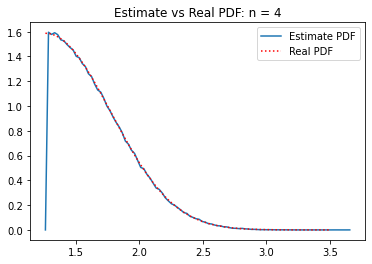

In [14]:
#Implementation for n = 4
#Generates bins of size delta
delta = .01
xmin = min(samples_4n)
xmax = max(samples_4n)
bincenters = np.linspace(xmin,xmax,int(1/delta))

#PDF Estimate
pdf_est = np.zeros(len(bincenters))
for i in range(1,len(bincenters)):
    pdf_est[i] = np.count_nonzero((samples_4n > bincenters[i]-delta/2) & (samples_4n <= bincenters[i]+delta/2) )/n_samples/delta 

#PDF Real
x1 = 2**(1/3)
x_real = np.linspace(x1,3.5,1000)
g_x = x_real**2*np.exp(-x_real**3/3)
c = np.exp(2/3)

#Plots PDF Estimate and Real PDF
plt.title("Estimate vs Real PDF: n = 4")
plt.plot(bincenters,pdf_est, label = "Estimate PDF")

plt.plot(x_real,c*g_x, 'r:',label = "Real PDF")
plt.legend()

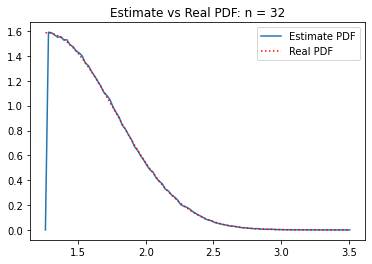

In [13]:
#Implementation for n = 32
#Generates bins of size delta
delta = .01
xmin = min(samples_32n)
xmax = max(samples_32n)
bincenters = np.linspace(xmin,xmax,int(1/delta))

#PDF Estimate
pdf_est = np.zeros(len(bincenters))
for i in range(1,len(bincenters)):
    pdf_est[i] = np.count_nonzero((samples_32n > bincenters[i]-delta/2) & (samples_32n <= bincenters[i]+delta/2) )/n_samples/delta 

#PDF Real
x1 = 2**(1/3)
x_real = np.linspace(x1,3.5,1000)
g_x = x_real**2*np.exp(-x_real**3/3)
c = np.exp(2/3)

#Plots PDF Estimate and Real PDF
plt.title("Estimate vs Real PDF: n = 32")
plt.plot(bincenters,pdf_est, label = "Estimate PDF")

plt.plot(x_real,c*g_x, 'r:',label = "Real PDF")
plt.legend()

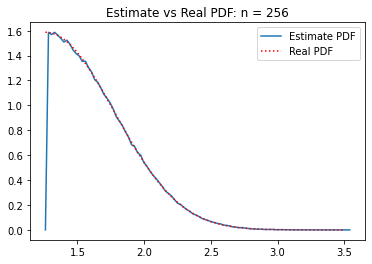

In [12]:
#Implementation for n = 256
#Generates bins of size delta
delta = .01
xmin = min(samples_256n)
xmax = max(samples_256n)
bincenters = np.linspace(xmin,xmax,int(1/delta))

#PDF Estimate
pdf_est = np.zeros(len(bincenters))
for i in range(1,len(bincenters)):
    pdf_est[i] = np.count_nonzero((samples_256n > bincenters[i]-delta/2) & (samples_256n <= bincenters[i]+delta/2) )/n_samples/delta 

#PDF Real
x1 = 2**(1/3)
x_real = np.linspace(x1,3.5,1000)
g_x = x_real**2*np.exp(-x_real**3/3)
c = np.exp(2/3)

#Plots PDF Estimate and Real PDF
plt.title("Estimate vs Real PDF: n = 256")
plt.plot(bincenters,pdf_est, label = "Estimate PDF")

plt.plot(x_real,c*g_x, 'r:', label = "Real PDF")
plt.legend()